# Atomistic Hamiltonians via interfacing with external electronic structure codes

## Table of Content: <a name="TOC"></a>

1. [Defining atomistic Hamiltonians via interfacing Libra with electronic structure packages](#define_atomistic)

 1.1. [Interfacing Libra and PSI4](#interface-psi4)
 
 1.2. [Interfacing Libra and DFTB+](#interface-dftbp)
 
   
2. [PES plotting and scans](#pes)

 2.1. [PES for LiH molecule via EOM-CCSD](#pes_scan-1)
 
 2.2. [PES for HFCO molecule via TD-DFTB](#pes_scan-2)
  

## A. Learning objectives

- to be able to define Hamiltonian computation function based on interface with external electronic structure codes
- to be able to define Hamiltonian computation function based on interface with Psi4 electronic structure code
- to be able to define Hamiltonian computation function based on interface with DFTB+ electronic structure code
- to be able to use the defined atomistic Hamiltonians in computing PES
- to be able to build PES via mapping 1D reaction coordinate onto many-DOF molecular geometry transformation


## B. Use cases

- [Define Libra/Psi4 intraface Hamiltonian](#interface-psi4)
- [Define Libra/DFTB+ intraface Hamiltonian](#interface-dftbp)
- [Plotting LiH EOM-CCSD/sto-3G PES](#pes_scan-1)
- [Plotting HFCO TD-DFTB mapped 1D PES](#pes_scan-2)
- [Generate XYZ trajectory from a list of matrices](#make_path_xyz2)
- [Visualize the MD trajectories with py3Dmol](#md_trajectory-vis)


## C. Functions

- `libra_py`
  - `DFTB_methods`
   - [`read_dftb_output`](#read_dftb_output)
   - `run_dftb_adi` [Ex1](#run_dftb_adi-ex1) | [Ex2](#run_dftb_adi-ex2)
   - [`make_dftb_input`](#make_dftb_input)
  - `dynamics_plotting`
   - `plot_pes_properties` [Ex1](#plot_pes_properties-ex1) | [Ex2](#plot_pes_properties-ex2) 
  - `psi4_methods`
   - `run_psi4_adi` [Ex1](#run_psi4_adi-ex1) | [Ex2](#run_psi4_adi-ex2)
  - `scan`
   - `coords2xyz` [Ex1](#coords2xyz-ex1) | [Ex2](#coords2xyz-ex2)
   - [`make_path_xyz2`](#make_path_xyz2)

## D. Classes and class members
    
None  



In [1]:
import sys
import cmath
import math
import os
import h5py
#import psi4

import matplotlib.pyplot as plt   # plots
import numpy as np



if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py.data_visualize import colors, clrs_index
import libra_py.dynamics_plotting as dynamics_plotting
import libra_py.scan as scan
#import libra_py.psi4_methods as psi4_methods
import libra_py.packages.dftbplus.methods as DFTB_methods

import py3Dmol   # molecular visualization

%matplotlib inline 

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

<a name="define_atomistic"></a>[Back to TOC](#TOC)
## 1. Defining atomistic Hamiltonians via Interfacing Libra with electronic structure packages

In this and the following sections, we are going to adapt the process of defining model Hamiltonians to the realm of atomistic electronic structure calculations.

We are going to preserve the interface of the function that can be passed to the dynamical calculations ( a.k.a. `compute_model`) to what it was in the [model Hamiltonian examples](../1_pes_plotting/tutorial.ipynb), but we will change what is going on inside these `compute_model` functions. 

For refresher on how the function's input and output parameters, please see [this tutorial](../1_pes_plotting/tutorial.ipynb)



<a name="interface-psi4"></a>[Back to TOC](#TOC)
### 1.1. Interfacing Libra with [Psi4](#http://www.psicode.org/)

The function below demonstrates how one can interface Libra with the Psi4 code.

The input parameters are described in the corresponding docstring, here we just discuss some aspects:


1. The user can specify the methods/basis to use for computing the ground and excited state energies and the corresponding gradients. For the full range of options, one is referred to the [Psi4](#http://www.psicode.org/) documentation. Some possible options for computing energies and gradients are:
   
   Ground state energies and gradients:  
    - "pbe/sto-3g"
    - "mp2/aug-cc-pVDZ"
    - "ccsd/aug-cc-pVDZ"
    
   Excited state energies and gradients:  
    - "eom-ccsd/aug-cc-pVDZ"
    
   Excited state energies, no gradients:  
    - "cisd/aug-cc-pVDZ"
    - "adc/aug-cc-pVDZ"
    
2. The `options` parameter is used to further control the execution of the Psi4 calculations, for instance:

   - `'prop_root':istate` - can be used to indicate for which rood (state) we are going to compute properties 
   This is important if we want to obtain state-resolved gradients, for instance
   
   - `'roots_per_irrep':[3, 0, 0, 0]` - one needs to indicate how many roots per each irreducible representation
   of the point group symmetries to which the molecular system belongs we need to compute
   
   - `'reference':'rohf'` - is used to indicate what type of reference wavefunction to use in the excited-states 
   calculations

3. This function defines only a subset of the Hamiltonian properties, so not all types of PES scan or dynamics can be executed with it:

       obj.ham_adi = CMATRIX(nstates, nstates)    
       obj.hvib_adi = CMATRIX(nstates, nstates)            
       obj.d1ham_adi = CMATRIXList();            
    
   The vibronic Hamiltonian, `hvib_adi` in this case contains only the electronic Hamiltonian part and not NACs
 
   More properties can be defined (such as `nac_adi`) in principle. 
 
4. Setting up a temporary file is a conveninet thing - if the files get large (and they can be so easily), you will know where to find it

       psi4.core.set_output_file('tmp.dat',False)
       
5. The geometry of the system for Psi4 is setup with the following block:

       mol = psi4.geometry(F"""
       {charge} {spin_multiplicity}
       {coords_str }

       units bohr
       """)

   To prepare the coordiantes of the xyz file, we use the auxiliary `coords2xyz` function from Libra:
   
       coords_str = scan.coords2xyz(labels, q, indx)
            
6. The energy is computed via:

       E, wfc = psi4.energy(grad_method_gs, molecule=mol, return_wfn=True)
       
   This call also request returning the converged wavefunction (the `wfc` object) - which is needed
   for properties calculations (gradients), but also can be used for NAC calculations


7. The gradients calculations goes like:

       grad = np.asarray(psi4.gradient(grad_method_ex, ref_wfn=wfc))
       
   Note how the previously returned wavefunction is used as the reference one.


8. For convenience, the function defined below is also defined in the `libra_py.psi4_methods.py` module. 

<a name="run_psi4_adi-ex1"></a>

In [2]:
class tmp:
    pass

def run_psi4_adi(q, params_, full_id):
    """
   
    This function executes the Psi4 quantum chemistry calculations and 
    returns the key properties needed for dynamical calculations.

    Args: 
        q ( MATRIX(ndof, ntraj) ): coordinates of the particle [ in Bohr units ]
        params ( dictionary ): model parameters
 
            * **params["labels"]** ( list of strings ): the labels of atomic symbolc - for all atoms,
                and in a order that is consistent with the coordinates (in triples) stored in `q`.
                The number of this labels is `natoms`, such that `ndof` = 3 * `natoms`. [ Required ]
            * **params["nstates"]** ( int ): the total number of electronic states 
                in this model [ default: 1 - just the ground state ]
            * **params["grad_method_gs"]** ( string ):  the name of the methodology to compute the 
                energy and gradients on the ground state [ defaut: "ccsd/sto-3g" ]
                Examples: 
                  "pbe/sto-3g", "mp2/aug-cc-pVDZ", "ccsd/aug-cc-pVDZ" # ground state energies, gradients                   
            * **params["grad_method_ex"]** ( string ):  the name of the methodology to compute the 
                energy and gradients on the excited states [ defaut: "eom-ccsd/sto-3g" ]
                Examples:                                     
                  "eom-ccsd/aug-cc-pVDZ", # excited state energies, gradients                  
                If you need just excited state energies (but not gradients), consider: 
                "cisd/aug-cc-pVDZ", adc/aug-cc-pVDZ                
            * **params["charge"]** ( int ): the total charge of the system [ default: 0 ]
            * **params["spin_multiplicity"]** ( int ): the total spin multiplicity [ default: 1 - singlet ]
            * **params["options"]** ( dictionary ): additional parameters of calculations [ default: empty ]
                Examples: 
                  - {} - noting extra
                  - {'reference':'rohf'}, 
                  - {'roots_per_irrep':[3, 0, 0, 0], 'prop_root':1, 'reference':'rohf'}
                  - {'num_roots':3, 'follow_root':2, 'reference':'rohf'} - for state-resolved gradients
            * **params["verbosity"]** ( int ): the level of output of the execution-related 
                information [ default : 0]
                  
        full_id ( intList ): the "path" to the Hamiltonian in the Hamiltonian's hierarchy. Usually, 
            this is Py2Cpp_int([0, itraj]) - the index of the trajectory in a swarm of trajectories
            
    Returns:       
        PyObject: obj, with the members:

            * obj.ham_adi ( CMATRIX(nstates,nstates) ): adiabatic Hamiltonian
            * obj.hvib_adi ( CMATRIX(nstates,nstates) ): vibronic Hamiltonian in the adiabatic basis
            * obj.d1ham_adi ( list of ndof CMATRIX(nstates, nstates) objects ): 
                derivatives of the adiabatic Hamiltonian w.r.t. the nuclear coordinate            
 
    """

    # Make a copy of the input parameters dictionary
    params = dict(params_)
    
    # Defaults    
    critical_params = [ "labels" ] 
    default_params = { "nstates":1,
                       "grad_method_gs":"ccsd/sto-3g", 
                       "grad_method_ex":"eom-ccsd/sto-3g", 
                       "charge":0, "spin_multiplicity":1,                       
                       "options":{},
                       "verbosity":0
                     }
    comn.check_input(params, default_params, critical_params)
    
    # Extract the key variables
    grad_method_gs = params["grad_method_gs"]
    grad_method_ex = params["grad_method_ex"]
    charge = params["charge"]
    spin_multiplicity = params["spin_multiplicity"]
    labels = params["labels"]    
    nstates = params["nstates"]
    options = params["options"]
    verbosity = params["verbosity"]
    natoms = len(labels)
    ndof = 3 * natoms
    
    
    obj = tmp()
    obj.ham_adi = CMATRIX(nstates, nstates)    
    obj.hvib_adi = CMATRIX(nstates, nstates)            
    obj.d1ham_adi = CMATRIXList();            
    for idof in range(ndof):        
        obj.d1ham_adi.append( CMATRIX(nstates, nstates) )
  

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    # Setup and execute the PSI4 calculations
    psi4.core.set_output_file('tmp.dat', False)    
    coords_str = scan.coords2xyz(labels, q, indx)

    mol = psi4.geometry(F"""
    {charge} {spin_multiplicity}
    {coords_str }

    units bohr
    """)
                
    for istate in range(nstates):

        E, grad = None, None
        if istate == 0:
                        
            # Compute the energy 
            if verbosity >0:
                print("Doing state 0 energy")
                
            print(grad_method_gs, mol)
            E, wfc = psi4.energy(grad_method_gs, molecule=mol, return_wfn=True)                        

            # Compute force at the converged density
            if verbosity >0:
                print("Doing state 0 gradient")
            grad = np.asarray(psi4.gradient(grad_method_gs, ref_wfn=wfc))            
            
        else:
    
            opt = dict(options)
            opt.update({ 'prop_root':istate, 'roots_per_irrep':[3, 0, 0, 0],  'reference':'rohf'  })
            psi4.set_options(opt)

            # Compute the energy 
            if verbosity >0:
                print(F"Doing state {istate} energy")
                
            E, wfc = psi4.energy(grad_method_ex, molecule=mol, return_wfn=True)

            # Compute force at the converged density
            if verbosity >0:
                print(F"Doing state {istate} gradient")
            
            grad = np.asarray(psi4.gradient(grad_method_ex, ref_wfn=wfc))

        
        obj.ham_adi.set(istate, istate, E * (1.0+0.0j) )
        obj.hvib_adi.set(istate, istate, E * (1.0+0.0j) )        
        for iatom in range(natoms):        
            obj.d1ham_adi[3 * iatom + 0].set(istate, istate, grad[iatom, 0] * (1.0+0.0j) )
            obj.d1ham_adi[3 * iatom + 1].set(istate, istate, grad[iatom, 1] * (1.0+0.0j) )
            obj.d1ham_adi[3 * iatom + 2].set(istate, istate, grad[iatom, 2] * (1.0+0.0j) )
        
                        
    return obj


Below, we are going to demonstrate the use of this function for computing properties of the LiH molecule.

Lets first look what the `coords2xyz` function does:
<a name="coords2xyz-ex1"></a>

In [3]:
%%time 

labels = ["Li", "H"]
q = MATRIX(6,1)
q.set(0,0, 0.0);  q.set(1,0, 0.0); q.set(2,0, 0.0);
q.set(3,0, 0.0);  q.set(4,0, 0.0); q.set(5,0, 1.5);

print( scan.coords2xyz( labels, q, 0) )

Li  0.0 0.0 0.0
H  0.0 0.0 1.5

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 532 µs


Now we can specify some system-specific parameters:

* `labels: ["Li", "H"]` - this is all we have in the LiH molecule

* `nstates: 3` - we are going to compute 3 states (all singlets)

* `verbosity:1` - add some progress printing

<a name="run_psi4_adi-ex2"></a>

In [4]:
%%time 

params_ = { "labels": labels, "nstates":3, "verbosity":1    }
inp_id = Py2Cpp_int([0, 0])
obj_psi4 = run_psi4_adi(q, params_, inp_id)

Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff87564be90>
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 2 energy
Doing state 2 gradient
CPU times: user 2.08 s, sys: 15 s, total: 17 s
Wall time: 44.5 s


Repeat the same calculation, but using the "standard" (part of the Libra distribution) code, imported with the `psi4_methods` module:

In [5]:
%%time 

params_ = { "labels": labels, "nstates":3, "verbosity":1    }
id = Py2Cpp_int([0, 0])
obj_psi4 = psi4_methods.run_psi4_adi(q, params_, id )

Doing state 0 energy
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 2 energy
Doing state 2 gradient
CPU times: user 2.45 s, sys: 14.9 s, total: 17.3 s
Wall time: 43.5 s


The returned object contains all the properties defined in the function discussed above.

So, we can now access them (as the class data members) and perhaps store them (using the methods of the CMATRIX class - the data type of the `obj.ham_adi`, etc.) 

In [6]:
prefix = "lih"
obj_psi4.ham_adi.show_matrix(F"{prefix}-ham_adi.txt")
obj_psi4.d1ham_adi[0].show_matrix(F"{prefix}-d1ham_adi-0.txt")
obj_psi4.d1ham_adi[1].show_matrix(F"{prefix}-d1ham_adi-1.txt")

<a name="interface-dftbp"></a></a>[Back to TOC](#TOC)
### 1.2. Interfacing Libra with [DFTB+](#https://www.dftbplus.org/)

In this section, we'll go over the way to create an interface bettween Libra and DFTB+ code. 

The assumption is that we are using DFTB+ in to compute the TD-DFTB excited states via Casida's method. 

For such calculations, we need a template input file `dftb_input_template.hsd`, which is located in this directory and is a part of this tutorial. You can specify most of the details on how to conduct the calculations in this file, except for several places that merely serve as the placeholdels and would be modified in actual calculations:

1. Specification of the input geometry: 

       Geometry = GenFormat {
          <<< "input_name,gen"
       }
   
   
2. Specification of the state of interest:

       StateOfInterest    = some_state_index_here
   
   
3. Specification of the type of the forces to be computed:

       ExcitedStateForces = yes


During the actual execution, the template file will be used to create the actual working input file (always called `dftb_in.hsd`) and these fields would be changed accordingly. 

In addition, depending on your system, you may need to obtain the corresponding Slater-Koster files. In this tutorial, we are looking at the fluoro-formaldehyde HFCO, so we need to use the [halogen-organics SK files set](https://www.dftb.org/parameters/download/halorg/halorg-0-1-cc/)


Before we define the Libra-DFTB+ Hamiltonian computation function, it is convenient to define the axusiliary functions for creating input and reading the output (the `detailed.out`) files associated with DFTB+

As mentioned above, the `make_dftb_input` function simply updates the placeholder fields:

<a name="make_dftb_input"></a>

In [2]:
def make_dftb_input(dftb_input_template_filename, istate):
    """
    This function creates an input file for DFTB+ package from a template file,
    it changes several placeholder lines to ensure the calculations are done
    for required electronic states
    
    Args: 
        dftb_input_template_filename ( strings ): the name of the generic input file (template) 
            for DFTB+ calculations
            
        istate ( int ): the index of the state, for which the calculations will be carried out
        
    Returns:
        None :  just creates the files
        
    """
    
    # Read in the template file
    f = open(dftb_input_template_filename, 'r')
    dftb_input_template = f.readlines()
    f.close() 

    
    nlines = len(dftb_input_template)
    
    # Create the actual output file - just replace few parameters in the template file
    dftb_input = open("dftb_in.hsd","w");     
    
    for i in range( nlines ):                
        
        dftb_input_template_line = dftb_input_template[i].split()
        
        
        if len(dftb_input_template_line) > 0:
                    
            if dftb_input_template_line[0] == "<<<":
                dftb_input.write( '    <<< "tmp.gen"\n ')

            elif dftb_input_template_line[0] == "StateOfInterest":
                dftb_input.write( F"    StateOfInterest    = {istate}\n" )

            elif istate == 0 and dftb_input_template_line[0] == "ExcitedStateForces":
                dftb_input.write( "    ExcitedStateForces = no\n" )

            else:
                dftb_input.write(dftb_input_template[i])
                
        else:
            dftb_input.write(dftb_input_template[i])

                    
    dftb_input.close()


The `read_dftb_output` function reads in the total energy (essentially the reference, ground state energy), the excitation energies, and the corresponding forces on all atoms. 

<a name="read_dftb_output"></a>

In [3]:
def read_dftb_output(natoms, istate):
    """
    This file reads in the total energy (essentially the reference, ground state energy), 
    the excitation energies, and the corresponding forces on all atoms and return them in 
    a digital format for further processing.
    
    Args:
    
        natoms ( int ): the number of atoms in the systemm
        istate ( int ): the index of the calculation - just for archiving purposes
        
    Returns: 
        double, MATRIX(ndof, 1): the total energy of a given electronic state,         
            and the corresponding gradients
    """
    
    # Check the successful completion of the calculations like this:
    if os.path.isfile('detailed.out'):
        #print("Found detailed.out")
        os.system(F"cp detailed.out detailed_{istate}.out")
    else:
        print("\nCannot find the file detailed.out")
        print(F"Hint: Current working directory is: {os.getcwd()}")
        print("Is this where you expect the file detailed.out to be found?")
        print("Exiting program...\n")
        sys.exit(0)
            
    
    ndof = 3 * natoms
    grad = MATRIX(ndof, 1)
    
    
    f = open("detailed.out")
    output = f.readlines()
    f.close()
    
    E = 0.0
    nlines = len(output)
            
    for i in range( nlines ):

        output_line = output[i].split()

        if len( output_line ) >= 2:
            
            if output_line[0] == "Total" and output_line[1] == "Forces":

                for j in range( natoms ):

                    next_lines = output[i+j+1].split()  

                    grad.set( 3*j+0, 0, -float(next_lines[1]) )
                    grad.set( 3*j+1, 0, -float(next_lines[2]) )
                    grad.set( 3*j+2, 0, -float(next_lines[3]) )

            if output_line[0] == "Excitation" and output_line[1] == "Energy:" :
            
                E += float(output_line[2])  # energy in a.u.
                #print(output_line[2])
                
            if output_line[0] == "Total" and output_line[1] == "energy:" :
                
                E += float(output_line[2])  # energy in a.u.
                #print(output_line[2])
    
    #print(F"Final energy = {E}")
    return E, grad          

Finally, we are redy to define the required interface function:

Once the parameters are read in (and verified, default values are used where needed), the flow is rather straightforward:

<a name="coords2xyz-ex2"></a>

1. Create a temporary .xyz file using the `scan.coords2xyz` function:

       coords_str = scan.coords2xyz(labels, q, indx, 1.0/units.Angst)
       f = open("tmp.xyz", "w"); 
       f.write( F"{natoms}\nTemporary xyz file\n{coords_str}" )
       f.close()

   Note the needed units conversion - the DFTB+ expects the .xyz files to list the coordinates in Ansgstrom (at least with the current template), but Libra internally uses Bohrs, so it is likely that the input will be in Bohrs.
   
2. Convert the .xyz file to the .gen file using the **xyz2gen** tool supplied with DFTB+

       os.system(F"{xyz2gen_exe} tmp.xyz")
       
   Here, note the following:
   
   - the intermediate files should be called tmp.xyz and tmp.gen - this is what is expected the generated input file will also list
   
   - the xyz2gen tool should be working properly, so make sure you set up your `xyz2gen_exe` parameter correctly
   
   - also, for the correct execution of the xyz2gen tool, you may need to tweak the supplied code a bit: 
     if you are using conda-installed Python, the default python listed in the tool's shebang line may not be
     the one that you need to use. Then edit the topmost line of the "xyz2gen" file in your DFTB+ installation 
     to change it to point to the correct python executable. For instance, on my laptop, i set it up to something
     like this:
     
         #! /home/alexey/miniconda2/envs/py37/bin/python)

3. Then for each state: 

   - create input files:

         make_dftb_input(dftb_input_template_filename, istate)
         
   - execute the DFTB+ code:
   
         os.system( dftb_exe )
         
     This is where you need the `dftbp_exe` parameter - make sure it points to the correct executable (ending with dftb+)
     
   - read the outputs to extract the needed information:
   
         E, grad = read_dftb_output(natoms, istate)
     
   - store the variables in the allocated memory of the created object


As before, for convenience, the function defined below and the two auxiliary functions defined above are also defined in the `libra_py.DFTB_methods.py` module. 

<a name="run_dftb_adi-ex1"></a>

In [4]:
def run_dftb_adi(q, params_, full_id):
    """
   
    This function executes the DFTB+ quantum chemistry calculations and 
    returns the key properties needed for dynamical calculations.

    Args: 
        q ( MATRIX(ndof, ntraj) ): coordinates of the particle [ units: Bohr ]
        params ( dictionary ): model parameters

            * **params["labels"]** ( list of strings ): the labels of atomic symbolc - for all atoms,
                and in a order that is consistent with the coordinates (in triples) stored in `q`.
                The number of this labels is `natoms`, such that `ndof` = 3 * `natoms`. [ Required ]                
            * **params["nstates"]** ( int ): the total number of electronic states 
                in this model [ default: 1 - just the ground state]                     
            * **params["dftb_input_template_filename"]** ( string ):  the name of the input file template
                [ default: "dftb_input_template.hsd" ]                
            * **params["dftbp_exe"]** ( string ):  the full path to the DFTB+ executable 
                [ defaut: "dftb+" ]
            * **params["xyz2gen_exe"]** ( string ):  the full path to the xyz2gen executable 
                (part of the DFTB+ package) [ defaut: "xyz2gen" ]                
                Note: sometimes, especially if you are using conda-installed Python, you may need to
                edit the "xyz2gen" file in your DFTB+ installation to change the topmost line to 
                point to the correct python executable (e.g. #! /home/alexey/miniconda2/envs/py37/bin/python)            
                            
    Returns:       
        PyObject: obj, with the members:

            * obj.ham_adi ( CMATRIX(nstates,nstates) ): adiabatic Hamiltonian             
            * obj.d1ham_adi ( list of ndof CMATRIX(nstates, nstates) objects ): 
                derivatives of the adiabatic Hamiltonian w.r.t. the nuclear coordinate            
 
    """

    params = dict(params_)
    
    critical_params = [ "labels" ] 
    default_params = { "dftb_input_template_filename":"dftb_input_template.hsd",     
                       "nstates":1,
                       "dftb_exe":"dftb+",  "xyz2gen_exe":"xyz2gen"
                     }
    comn.check_input(params, default_params, critical_params)
        
    labels = params["labels"]      
    dftb_input_template_filename = params["dftb_input_template_filename"]
    nstates = params["nstates"]    
    dftb_exe = params["dftb_exe"]
    xyz2gen_exe = params["xyz2gen_exe"]
    
    natoms = len(labels)
    ndof = 3 * natoms
    
    
    obj = tmp()
    obj.ham_adi = CMATRIX(nstates, nstates)    
    obj.nac_adi = CMATRIX(nstates, nstates)    
    obj.hvib_adi = CMATRIX(nstates, nstates)            
    obj.d1ham_adi = CMATRIXList();            
    for idof in range(ndof):        
        obj.d1ham_adi.append( CMATRIX(nstates, nstates) )
  

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    
    # Make an xyz file
    # since the DFTB+ expects the coordinates in Angstrom, but Libra 
    # goes with atomic units (Bohrs), hence expecting the `q` variable be 
    # in Bohrs, we need to convert the coordinates from Bohrs to Angstroms
    coords_str = scan.coords2xyz(labels, q, indx, 1.0/units.Angst)
    f = open("tmp.xyz", "w"); 
    f.write( F"{natoms}\nTemporary xyz file\n{coords_str}" )
    f.close()
        
    # Convert xyz to gen format: tmp.xyz -> tmp.gen
    # The temporary working file MUST be called "tmp.gen" since this is
    # what the DFTB+ input will list - see the `make_dftbp_input`
    os.system(F"{xyz2gen_exe} tmp.xyz")

        
    for istate in range(nstates):
        
        # Update the input file
        make_dftb_input(dftb_input_template_filename, istate)
        
        # We have written the dftb+ input file for a certain state in nstates. Now we must compute the 
        # state energies and forces. 
        os.system( dftb_exe )
        
        # At this point, we should have the "detailed.out" file created, so lets read it        
        E, grad = read_dftb_output(natoms, istate)

        # Now, populate the allocated matrices                
        obj.ham_adi.set(istate, istate, E * (1.0+0.0j) )
        obj.hvib_adi.set(istate, istate, E * (1.0+0.0j) )        
        for idof in range(ndof):        
            obj.d1ham_adi[idof].set(istate, istate, grad.get(idof, 0) * (1.0+0.0j) )                
    
                    
    return obj


Now, lets give it a try.

In this example, we are going to compute 3 states of the HFCO (fluoroformaldehyde) molecule, so: 

* `"labels":["F", "C", "H", "O"]` - this is the identity and the order of the atoms in our system

* `"nstates":3` - 3 states

Note how we the got the original coordinates in Angstrom, but before the calculations we convert them to Bohrs.

<a name="run_dftb_adi-ex2"></a>

In [5]:
%%time 

class tmp:
    pass

params_ = { "labels":["F", "C", "H", "O"], "nstates":3,
            "dftb_exe":"/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/_install/bin/dftb+",
            "xyz2gen_exe":"/home/alexvakimov/SOFTWARE/Conda/envs/libra/bin/xyz2gen"
          }

# This is the input in Angstrom
q = MATRIX(12,1)
q.set(0,0, -0.04746);  q.set(1,0,  0.65920);  q.set(2,0,  1.04080)
q.set(3,0, -0.51816);  q.set(4,0,  0.81540);  q.set(5,0,  0.06880)
q.set(6,0,  0.15264);  q.set(7,0,  1.00050);  q.set(8,0,  -0.77170)
q.set(9,0, -1.71206);  q.set(10,0, 0.78520);  q.set(11,0, -0.06860)
q.show_matrix()

# The input is expected to be in Bohr, so lets convert:
q *= units.Angst

id = Py2Cpp_int([0, 0])
obj_dftb = run_dftb_adi(q, params_, id )

-0.047460000  
0.65920000  
1.0408000   
-0.51816000  
0.81540000  
0.068800000  
0.15264000  
1.0005000   
-0.77170000  
-1.7120600  
0.78520000  
-0.068600000  

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.

    5   -0.99462002E+01    0.45987619E-03    0.13866250E-01
    6   -0.99480382E+01   -0.18379517E-02    0.15721249E-01
    7   -0.99480348E+01    0.34346499E-05    0.19763389E-02
    8   -0.99480487E+01   -0.13972325E-04    0.62691212E-04
    9   -0.99480489E+01   -0.21159735E-06    0.33934110E-07
   10   -0.99480489E+01   -0.21248425E-09    0.24026026E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4163884372 H         -256.2330 eV
Extrapolated to 0K:                 -9.6623681793 H         -262.9264 eV
Total Mermin free energy:           -9.4163884372 H         -256.2330 eV
Force related energy:               -9.6623681793 H         -262.9264 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.43 ( 69.1%

Again, repeat the same calculations using the imported functions from the "standard" Libra's modules:

In [6]:
%%time 

params_ = { "labels":["F", "C", "H", "O"], "nstates":3,
            "dftb_exe":"/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/_install/bin/dftb+",
            "xyz2gen_exe":"/home/alexvakimov/SOFTWARE/Conda/envs/libra/bin/xyz2gen"
          }

# This is the input in Angstrom
q = MATRIX(12,1)
q.set(0,0, -0.04746);  q.set(1,0,  0.65920);  q.set(2,0,  1.04080)
q.set(3,0, -0.51816);  q.set(4,0,  0.81540);  q.set(5,0,  0.06880)
q.set(6,0,  0.15264);  q.set(7,0,  1.00050);  q.set(8,0,  -0.77170)
q.set(9,0, -1.71206);  q.set(10,0, 0.78520);  q.set(11,0, -0.06860)
q.show_matrix()

# The input is expected to be in Bohr, so lets convert:
q *= units.Angst

id = Py2Cpp_int([0, 0])
obj_dftb = DFTB_methods.run_dftb_adi(q, params_, id )

-0.047460000  
0.65920000  
1.0408000   
-0.51816000  
0.81540000  
0.068800000  
0.15264000  
1.0005000   
-0.77170000  
-1.7120600  
0.78520000  
-0.068600000  

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.

    1    0.00000000E+00    0.00000000E+00    0.10037073E+01
    2   -0.99124245E+01   -0.99124245E+01    0.74164656E+00
    3   -0.99313299E+01   -0.18905394E-01    0.11388412E+00
    4   -0.99466601E+01   -0.15330189E-01    0.19261739E+00
    5   -0.99462002E+01    0.45987619E-03    0.13866250E-01
    6   -0.99480382E+01   -0.18379517E-02    0.15721249E-01
    7   -0.99480348E+01    0.34346499E-05    0.19763389E-02
    8   -0.99480487E+01   -0.13972325E-04    0.62691212E-04
    9   -0.99480489E+01   -0.21159735E-06    0.33934110E-07
   10   -0.99480489E+01   -0.21248425E-09    0.24026026E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -9.4163884372 H         -256.2330 eV
Extrapolated to 0K:                 -9.6623681793 H         -262.9264 eV
Total Mermin free energy:           -9.4163884372 H         -256.2330 eV
Force related energy:               -9.6623681793 H         -262.9264 eV


-------------------------------------------------------------

Analogously to the Psi4 example, the generated object can be used to save the computed results

In [7]:
prefix = "hfco"
obj_dftb.ham_adi.show_matrix(F"{prefix}-ham_adi.txt")
obj_dftb.d1ham_adi[0].show_matrix(F"{prefix}-d1ham_adi-0.txt")

<a name="pes"></a>
[Back to TOC](#TOC)

## 2. PES scan

Now, we will demonstrate the use of the above Hamiltonian calculations functions in building PES for ground excited states of some atomistic systems. 

We will be using the `plot_pes_properties` function of the `libra_py.dynamics_plotting` module. This most basic features of this function has been extensively discueed in [this tutorial](../1_pes_plotting/tutorial.ipynb). Here, we'll highlight a few additional features that can come handy with this function:


<a name="pes_scan-1"></a>
[Back to TOC](#TOC)

### 2.1. EOM-CCSD/STO-3G surfaces of LiH

In this example, we demonstrate the use of the following two parameters to perform a scan w.r.t. one of the DOFs in a many-DOF system like ours:

* `pes_params["active_dof"] = 5` - we are going to vary the DOF with index 5, which corresponds to the z coordinate of the second (H) atom.

* `pes_params["reference_coord"] = q` - we freeze all other DOFs to be what they are in the reference geometry `q` provided here.

<a name="plot_pes_properties-ex1"></a>

Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff8710a4290>
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff8ac63f770>
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff8710e8830>
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff8ac63f770>
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff8710e8890>
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff8ac63f770>
Doing state 0 gradient
Doing state 1 energy
Doing state 1 gradient
Doing state 0 energy
ccsd/sto-3g <psi4.core.Molecule object at 0x7ff8710e8830>
Doing state 0 gradient
Doing state 1 energy
D

No handles with labels found to put in legend.


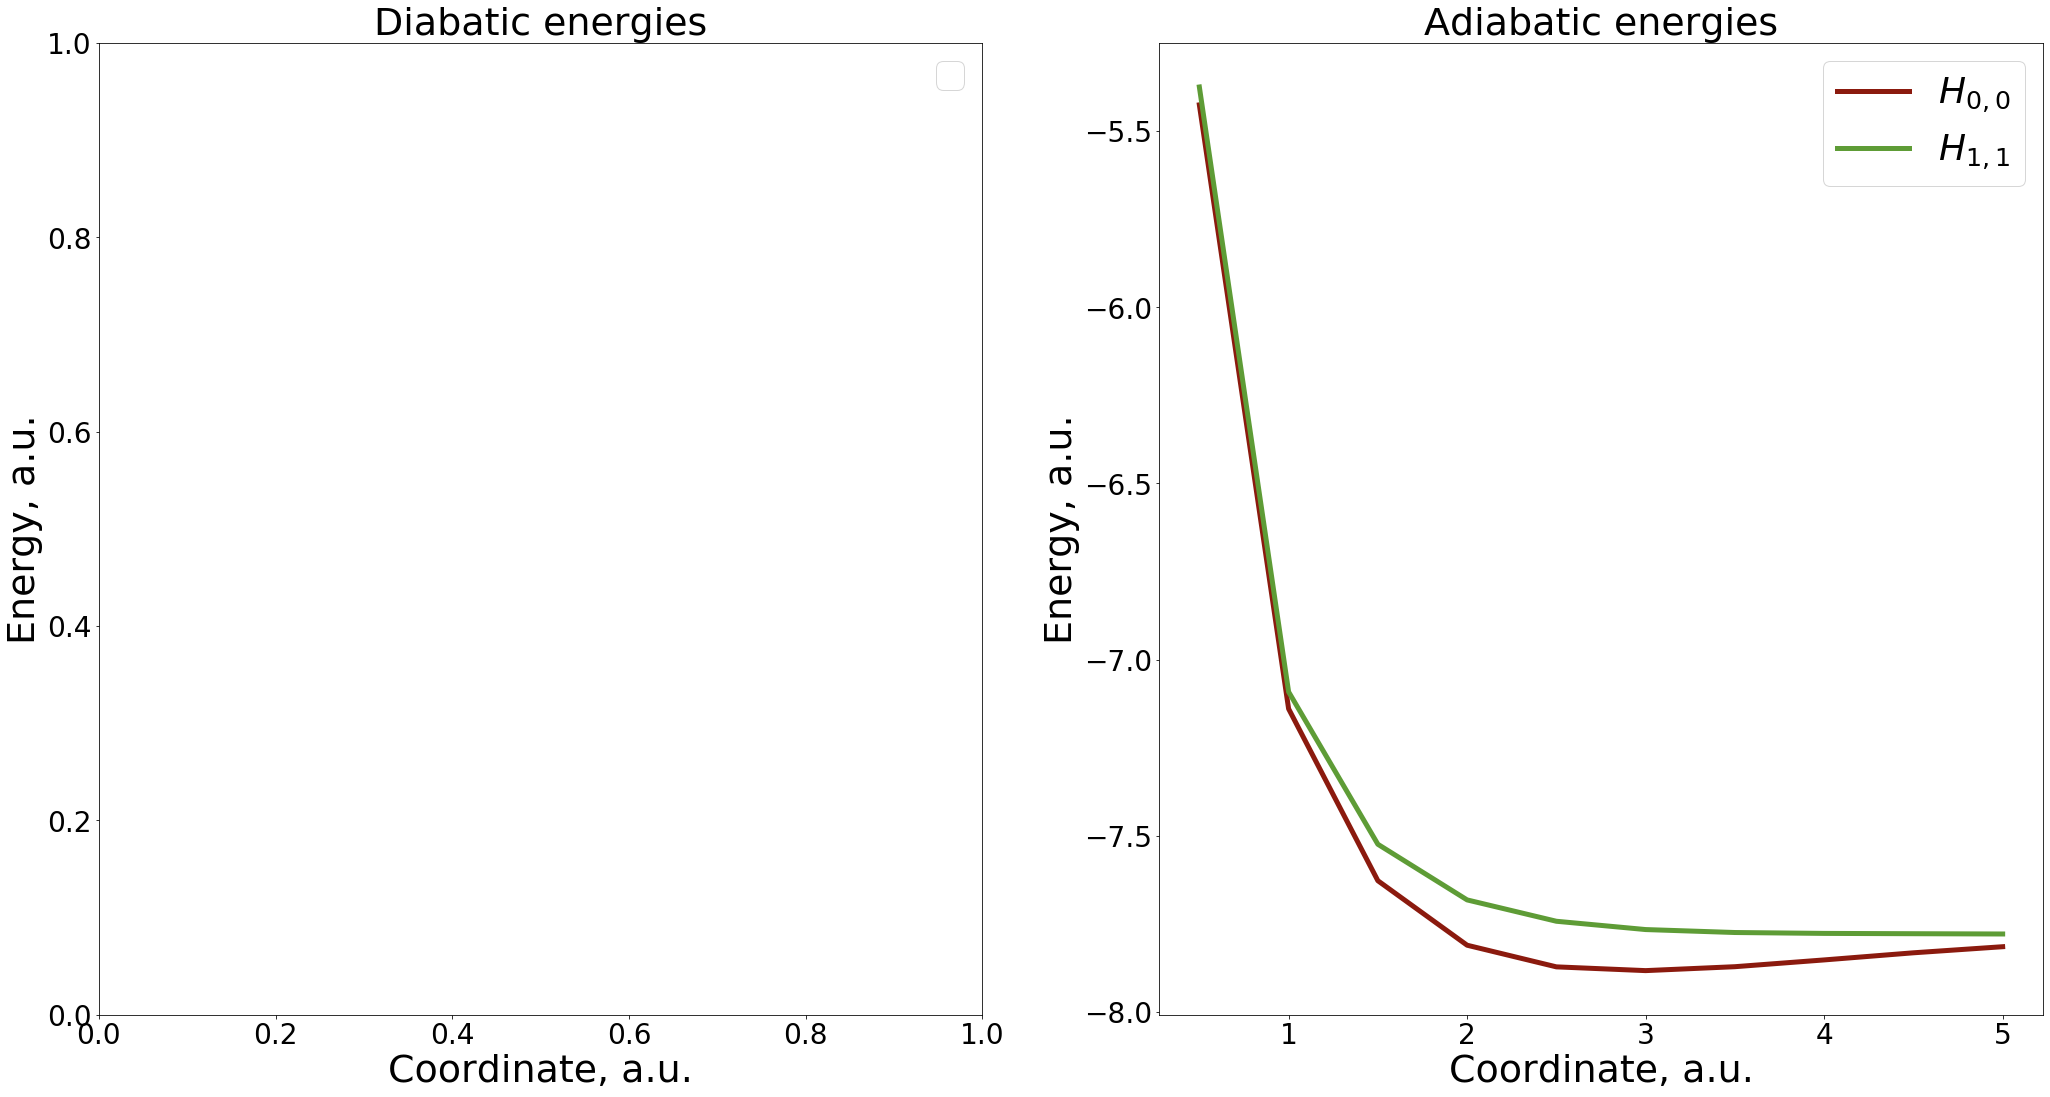

No handles with labels found to put in legend.


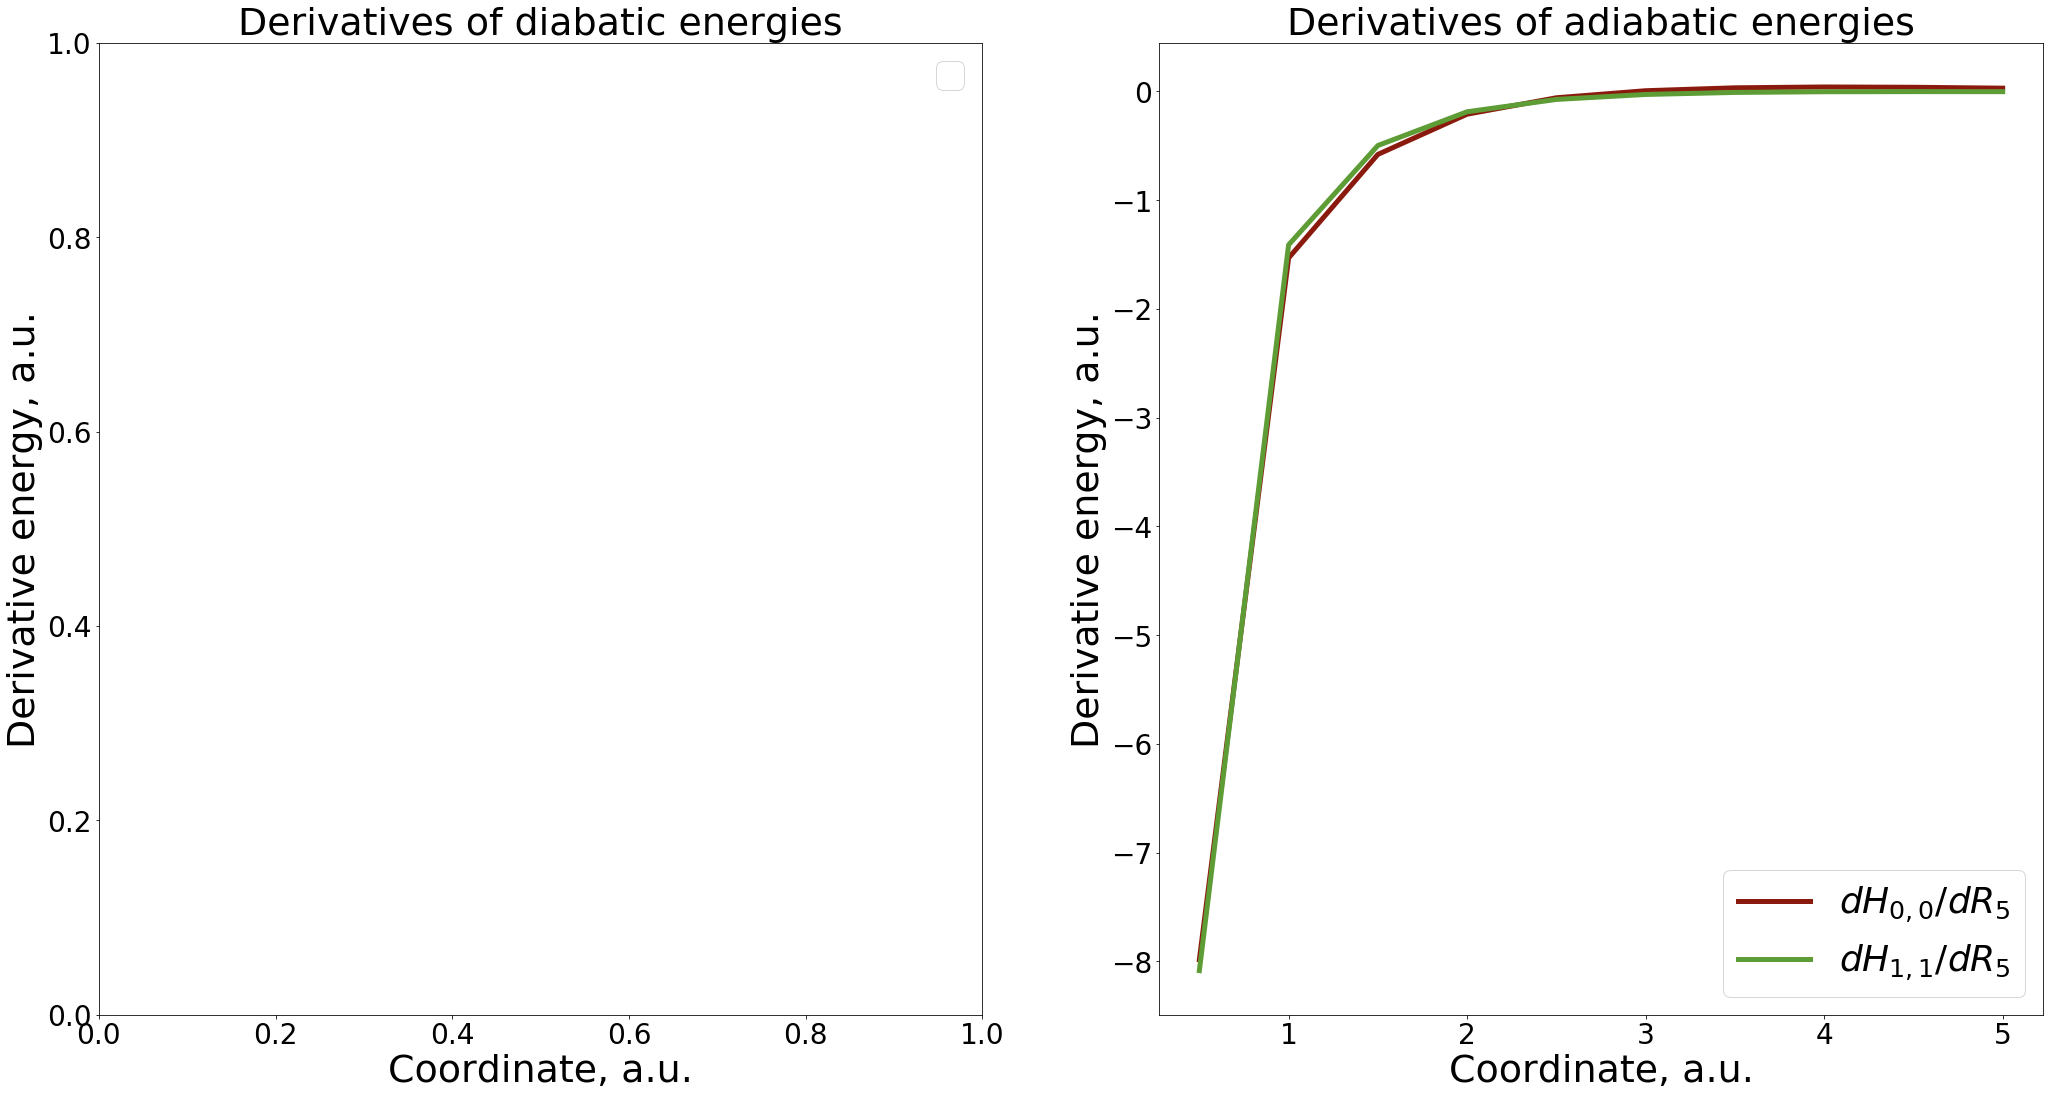

No handles with labels found to put in legend.
No handles with labels found to put in legend.


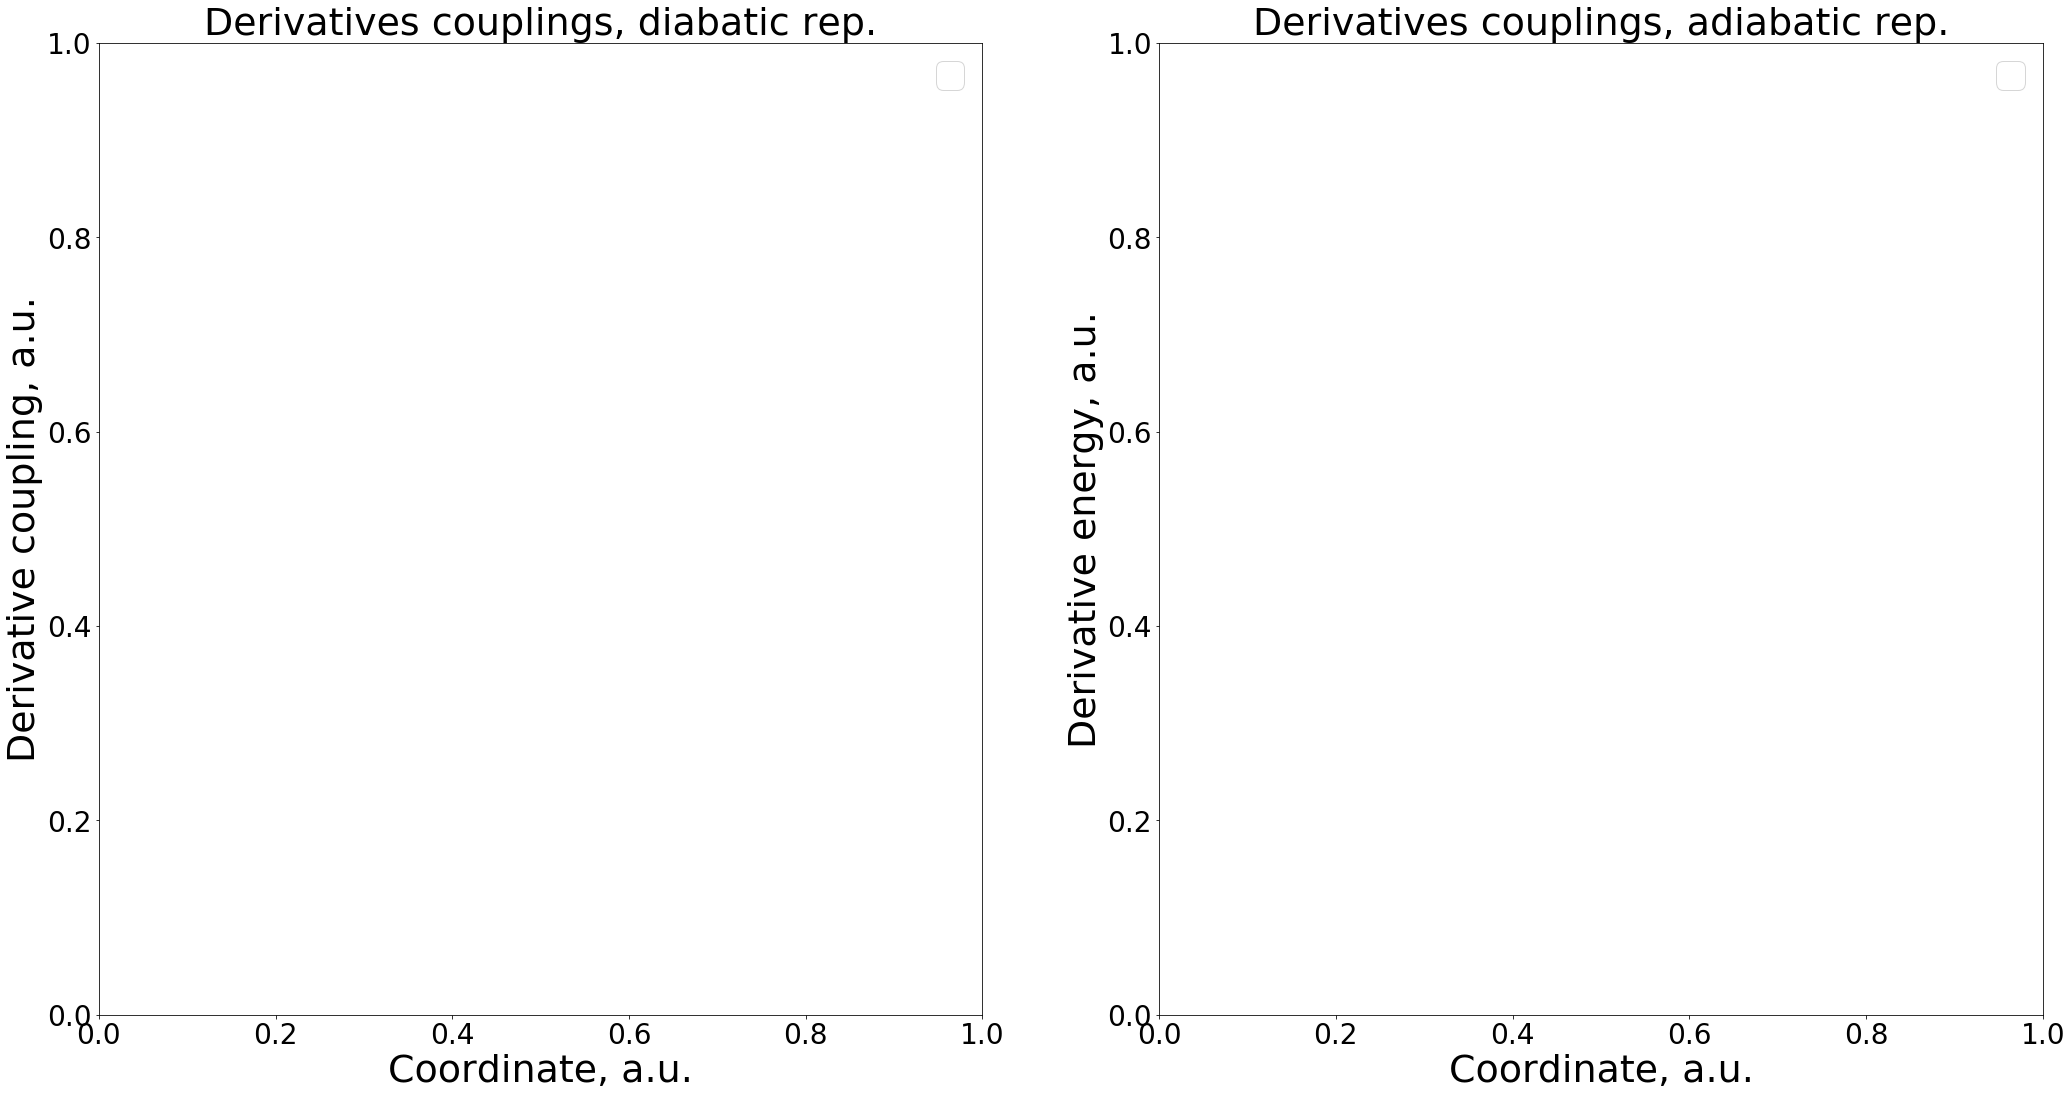

In [13]:
labels = ["Li", "H"]

# This geometry is assumed to be given in Bohrs already
q = MATRIX(6,1)
q.set(0,0, 0.0);  q.set(1,0, 0.0); q.set(2,0, 0.0);
q.set(3,0, 0.0);  q.set(4,0, 0.0); q.set(5,0, 1.5);
q.show_matrix()


model_params = { "labels":labels, "nstates":2, "verbosity":1 }

pes_params = { "ndia":2, "nadi":2, "ndof":6, "active_dof":5,
               "xmin":0.5, "xmax":5.0, "dx":0.5,
               "reference_coord":q,               
               "rep_tdse":1, "rep_ham":1  }

plot_params = { "which_ham_adi":[ [0,0], [1,1] ],
                "which_d1ham_adi":[ [5, 0,0], [5, 1,1] ],
                "colors": colors, "clrs_index": clrs_index
              }


LiH_scan = dynamics_plotting.plot_pes_properties(run_psi4_adi, model_params, pes_params, plot_params )

The generated variable `LiH_scan` contains the geometries of all configurations. 

We can use convert them to a xyz "trajectory" format for further visualization. 

<a name="make_path_xyz2"></a>

To do this, we use the `make_path_xyz2` function of the `libra_py.scan` module

Since the coordinates that we have generated in the `plot_pes_properties` are in Bohrs, and the visualizer of xyz files works best in Angstrom units, we need to use the conversion via `units.Angst` constant.

In [14]:
labels = ["Li", "H"]
itraj = 0
unit_conversion_factor = 1.0/units.Angst

LiH_xyz = scan.make_path_xyz2(labels, LiH_scan, itraj, unit_conversion_factor)

And now we can visuzlie this scan "trajectory" with py3Dmol:

<a name="md_trajectory-vis"></a>

In [15]:
view = py3Dmol.view(width=800,height=400)  
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(LiH_xyz, 'xyz')
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':1})
view.show()  


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<a name="pes_scan-2"></a>
[Back to TOC](#TOC)

### 2.2. TD-DFTB+ surfaces of HFCO

In this example, we are going to use the `run_dftpb_adi` function to construct ground and excited state surfaces of the HFCO molecule. Now, for such a scan it makes sense to choose some chemically-intuitive coordinate, such as bond-length for some of the bonds, say C-O. But how do we do this?

For this purpose, the function `plot_pes_properties` has yet another parameter, that we didn't need in previous situaitons. Namely, the `coord_mapping`. The value that corresponds to this key parameter is actually a Python **function!**. This function is meant to perform the mapping of the 1D scan coordinate on a multi-dimensional coordinate of our system that we are currently interested in. Defining such a function gives you the ultimate control of the scan "reaction" coordinate - it can be as complex as you want. But, again, we are looking to make the C-O bond of the HFCO molecule to be out reaction coordinate.

When the `coord_mapping` parameter is set to something other than `None` (either explicitly or by default), the parameters `reference_coord` and `active_dof` do not matter any more.

For this example, the coordinate mapping function is defined as following:

In [2]:
def mapping_function(coord):
    """
    Args:
        coord ( int ): the 1D "reaction" coordinate value          
            In this example, "coord" is the degree of the C - O bond elongation
            (1.0 - corresponding to the reference bond value)
            
    Returns:
        MATRIX(ndof, 1): the atomic coordinates of the system        
        
    """
    
    # Reference geometry in Angstrom
    q = MATRIX(12,1)
    q.set(0,0, -0.04746);  q.set(1,0,  0.65920);  q.set(2,0,  1.04080)   # F
    q.set(3,0, -0.51816);  q.set(4,0,  0.81540);  q.set(5,0,  0.06880)   # C
    q.set(6,0,  0.15264);  q.set(7,0,  1.00050);  q.set(8,0,  -0.77170)  # H
    q.set(9,0, -1.71206);  q.set(10,0, 0.78520);  q.set(11,0, -0.06860)  # O
    

    # Out result
    q_res = MATRIX(q)
    
    # r(O) - r(C)
    u = VECTOR()
    u.x = q.get(9,0) - q.get(3,0)
    u.y = q.get(10,0) - q.get(4,0)
    u.z = q.get(11,0) - q.get(5,0)
        
    q_res.set(9, 0,  q.get(3,0) + coord * u.x )
    q_res.set(10, 0,  q.get(4,0) + coord * u.y )
    q_res.set(11, 0,  q.get(5,0) + coord * u.z )
    
    
    # The input is expected to be in Bohr, so lets convert:
    q *= units.Angst
    
    return q_res
    
    

Now, we are ready to use the mapping function in the actual scan calculations:

<a name="plot_pes_properties-ex2"></a>

-0.089686395  
1.2457074   
1.9668268   
-0.97918042  
1.5408826   
0.13001315  
0.28844777  
1.8906709   
-1.4583015  
-3.2353243  
1.4838128   
-0.12963520  

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.hsd

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9191004
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self c


Total Energy:                       23.5479832341 H          640.7732 eV
Extrapolated to 0K:                 18.5801533609 H          505.5917 eV
Total Mermin free energy:           23.5479832341 H          640.7732 eV
Force related energy:               18.5801533609 H          505.5917 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       4.79 ( 64.1%)       0.31 ( 63.5%)
Post-SCC processing                    +       2.68 ( 35.8%)       0.17 ( 34.8%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.1%)       0.01 (  1.6%)
Total                                  =       7.47 (100.0%)       0.49 (100.0%)
----------------------------------------------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9193035
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 

|===============================================================================
|
|  DFTB+ development version (commit: 3f79963e, base: 22.2)
|
|  Copyright (C) 2006 - 2022  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.hsd'
Parser version: 13

--------------------------------------------------------------------------------
***  Converting input from parser version  4 to parser ver

    5   -0.89486196E+01   -0.95954260E-05    0.49371826E-03
    6   -0.89486208E+01   -0.12454643E-05    0.21787609E-03
    7   -0.89486208E+01   -0.12466401E-08    0.50670289E-07
    8   -0.89486208E+01   -0.28969183E-09    0.67874595E-11
>> Charges saved for restart in charges.bin

Total Energy:                        4.7462871305 H          129.1530 eV
Extrapolated to 0K:                  2.5868166453 H           70.3909 eV
Total Mermin free energy:            4.7462871305 H          129.1530 eV
Force related energy:                2.5868166453 H           70.3909 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       5.42 ( 65.5%)       0.35 ( 65.4%)
Post-SCC processing                    +       2.77 ( 33.5%)       0.17 ( 32.9%)
Post-geometry opt

    1    0.00000000E+00    0.00000000E+00    0.85179468E+00
    2   -0.89445376E+01   -0.89445376E+01    0.66512016E+00
    3   -0.89461739E+01   -0.16362333E-02    0.30421972E-01
    4   -0.89486100E+01   -0.24361209E-02    0.12461502E-01
    5   -0.89486196E+01   -0.95954260E-05    0.49371826E-03
    6   -0.89486208E+01   -0.12454643E-05    0.21787609E-03
    7   -0.89486208E+01   -0.12466401E-08    0.50670289E-07
    8   -0.89486208E+01   -0.28969183E-09    0.67874595E-11
>> Charges saved for restart in charges.bin

Total Energy:                        5.3247617031 H          144.8941 eV
Extrapolated to 0K:                  2.5868166453 H           70.3909 eV
Total Mermin free energy:            5.3247617031 H          144.8941 eV
Force related energy:                2.5868166453 H           70.3909 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9198066
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 

    5   -0.99689380E+01   -0.49254119E-04    0.17995691E-02
    6   -0.99689393E+01   -0.13197078E-05    0.89429917E-03
    7   -0.99689394E+01   -0.21020876E-07    0.40999928E-05
    8   -0.99689394E+01   -0.43289390E-08    0.74835249E-09
>> Charges saved for restart in charges.bin

Total Energy:                        0.6742338957 H           18.3468 eV
Extrapolated to 0K:                 -0.7591315344 H          -20.6570 eV
Total Mermin free energy:            0.6742338957 H           18.3468 eV
Force related energy:               -0.7591315344 H          -20.6570 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       6.00 ( 68.5%)       0.39 ( 68.7%)
Post-SCC processing                    +       2.75 ( 31.4%)       0.17 ( 29.9%)
-----------------

    1    0.00000000E+00    0.00000000E+00    0.12650711E+01
    2   -0.99431520E+01   -0.99431520E+01    0.97770710E+00
    3   -0.99537409E+01   -0.10588979E-01    0.74633684E-01
    4   -0.99688888E+01   -0.15147815E-01    0.32346642E-01
    5   -0.99689380E+01   -0.49254119E-04    0.17995691E-02
    6   -0.99689393E+01   -0.13197078E-05    0.89429917E-03
    7   -0.99689394E+01   -0.21020876E-07    0.40999928E-05
    8   -0.99689394E+01   -0.43289390E-08    0.74835249E-09
>> Charges saved for restart in charges.bin

Total Energy:                        0.9505094461 H           25.8647 eV
Extrapolated to 0K:                 -0.7591315344 H          -20.6570 eV
Total Mermin free energy:            0.9505094461 H           25.8647 eV
Force related energy:               -0.7591315344 H          -20.6570 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9202167
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 

    6   -0.10210260E+02   -0.84206118E-04    0.25533283E-02
    7   -0.10210261E+02   -0.12386888E-05    0.36697067E-03
    8   -0.10210261E+02   -0.65434662E-07    0.13667813E-05
    9   -0.10210261E+02   -0.27727953E-08    0.25051872E-09
>> Charges saved for restart in charges.bin

Total Energy:                       -0.3263318758 H           -8.8799 eV
Extrapolated to 0K:                 -1.4554803176 H          -39.6056 eV
Total Mermin free energy:           -0.3263318758 H           -8.8799 eV
Force related energy:               -1.4554803176 H          -39.6056 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       5.77 ( 68.8%)       0.37 ( 68.2%)
Post-SCC processing                    +       2.61 ( 31.1%)       0.16 ( 30.3%)
-----------------

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9204528
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   s

    5   -0.10256697E+02    0.11035404E-02    0.88433981E-01
    6   -0.10257898E+02   -0.12010174E-02    0.51681508E-01
    7   -0.10258131E+02   -0.23251026E-03    0.14706769E-01
    8   -0.10258239E+02   -0.10798415E-03    0.10992216E-03
    9   -0.10258248E+02   -0.95207875E-05    0.36305408E-06
   10   -0.10258248E+02   -0.53557514E-09    0.15107586E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -1.5673413438 H          -42.6495 eV
Extrapolated to 0K:                 -1.5673413438 H          -42.6495 eV
Total Mermin free energy:           -1.5673413438 H          -42.6495 eV
Force related energy:               -1.5673413438 H          -42.6495 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       7.64 ( 72.5%

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9207219
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self c

    9   -0.10258248E+02   -0.95207875E-05    0.36305408E-06
   10   -0.10258248E+02   -0.53557514E-09    0.15107586E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -0.7571554314 H          -20.6032 eV
Extrapolated to 0K:                 -1.5673413438 H          -42.6495 eV
Total Mermin free energy:           -0.7571554314 H          -20.6032 eV
Force related energy:               -1.5673413438 H          -42.6495 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
SCC                                    +       3.77 ( 57.1%)       0.25 ( 56.7%)
Post-SCC processing                    +       2.83 ( 42.8%)       0.18 ( 41.5%)
--------------------------------------------------------------------------------
Missing                                +       0.01 (  0

    1    0.00000000E+00    0.00000000E+00    0.19612524E+01
    2   -0.10047096E+02   -0.10047096E+02    0.15471393E+01
    3   -0.10089040E+02   -0.41943589E-01    0.25027711E+00
    4   -0.10185940E+02   -0.96899865E-01    0.32451953E+00
    5   -0.10180283E+02    0.56571791E-02    0.23037609E+00
    6   -0.10182586E+02   -0.23029852E-02    0.12226015E+00
    7   -0.10185920E+02   -0.33345116E-02    0.61024764E-01
    8   -0.10186833E+02   -0.91285303E-03    0.33480488E-02
    9   -0.10187127E+02   -0.29359665E-03    0.37166690E-04
   10   -0.10187127E+02   -0.86584457E-06    0.22729599E-05
   11   -0.10187127E+02   -0.10769341E-09    0.22334898E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -1.5053160021 H          -40.9617 eV
Extrapolated to 0K:                 -1.5053160021 H          -40.9617 eV
Total Mermin free energy:           -1.5053160021 H          -40.9617 eV
Force related energy:               -1.5053160021 H          -40.9617 eV


-

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-C.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9211426
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   s

    5   -0.10180283E+02    0.56571791E-02    0.23037609E+00
    6   -0.10182586E+02   -0.23029852E-02    0.12226015E+00
    7   -0.10185920E+02   -0.33345116E-02    0.61024764E-01
    8   -0.10186833E+02   -0.91285303E-03    0.33480488E-02
    9   -0.10187127E+02   -0.29359665E-03    0.37166690E-04
   10   -0.10187127E+02   -0.86584457E-06    0.22729599E-05
   11   -0.10187127E+02   -0.10769341E-09    0.22334898E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -1.0202242207 H          -27.7617 eV
Extrapolated to 0K:                 -1.5053160021 H          -40.9617 eV
Total Mermin free energy:           -1.0202242207 H          -27.7617 eV
Force related energy:               -1.5053160021 H          -40.9617 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------

    1    0.00000000E+00    0.00000000E+00    0.19884479E+01
    2   -0.99545863E+01   -0.99545863E+01    0.15826787E+01
    3   -0.99876498E+01   -0.33063553E-01    0.28760736E+00
    4   -0.10075872E+02   -0.88222087E-01    0.45447689E+00
    5   -0.10062295E+02    0.13576695E-01    0.12454483E+00
    6   -0.10077641E+02   -0.15346176E-01    0.23797142E+00
    7   -0.10071867E+02    0.57746277E-02    0.70120854E-01
    8   -0.10079120E+02   -0.72531272E-02    0.28136695E-01
    9   -0.10079645E+02   -0.52467363E-03    0.98597995E-03
   10   -0.10079744E+02   -0.98975608E-04    0.13677325E-04
   11   -0.10079744E+02   -0.11941305E-06    0.88666073E-06
   12   -0.10079744E+02   -0.23092639E-10    0.18183235E-07
   13   -0.10079744E+02   -0.90594199E-13    0.59596772E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -1.4001431832 H          -38.0998 eV
Extrapolated to 0K:                 -1.4001431832 H          -38.0998 eV
Total Mermin free energy:    

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9216177
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self c

    5   -0.10062295E+02    0.13576695E-01    0.12454483E+00
    6   -0.10077641E+02   -0.15346176E-01    0.23797142E+00
    7   -0.10071867E+02    0.57746277E-02    0.70120854E-01
    8   -0.10079120E+02   -0.72531272E-02    0.28136695E-01
    9   -0.10079645E+02   -0.52467363E-03    0.98597995E-03
   10   -0.10079744E+02   -0.98975608E-04    0.13677325E-04
   11   -0.10079744E+02   -0.11941305E-06    0.88666073E-06
   12   -0.10079744E+02   -0.23092639E-10    0.18183235E-07
   13   -0.10079744E+02   -0.90594199E-13    0.59596772E-12
>> Charges saved for restart in charges.bin

Total Energy:                       -1.0904698723 H          -29.6732 eV
Extrapolated to 0K:                 -1.4001431832 H          -38.0998 eV
Total Mermin free energy:           -1.0904698723 H          -29.6732 eV
Force related energy:               -1.4001431832 H          -38.0998 eV


--------------------------------------------------------------------------------
DFTB+ running times                     

    1    0.00000000E+00    0.00000000E+00    0.19968830E+01
    2   -0.98694087E+01   -0.98694087E+01    0.15950621E+01
    3   -0.98972103E+01   -0.27801611E-01    0.39452619E+00
    4   -0.99396451E+01   -0.42434774E-01    0.63272661E+00
    5   -0.99456047E+01   -0.59595642E-02    0.52342745E+00
    6   -0.99520720E+01   -0.64673257E-02    0.10021700E+01
    7   -0.97624741E+01    0.18959786E+00    0.21427076E+00
    8   -0.99733570E+01   -0.21088284E+00    0.25743881E+00
    9   -0.99673189E+01    0.60380686E-02    0.93268024E-01
   10   -0.99789555E+01   -0.11636545E-01    0.80138114E-01
   11   -0.99793894E+01   -0.43394909E-03    0.87693774E-02
   12   -0.99805880E+01   -0.11985660E-02    0.13955822E-02
   13   -0.99806017E+01   -0.13709402E-04    0.59049725E-04
   14   -0.99806020E+01   -0.35636052E-06    0.33111363E-05
   15   -0.99806020E+01   -0.63247008E-09    0.77705410E-07
   16   -0.99806020E+01   -0.19966251E-11    0.21370461E-10
>> Charges saved for restart in charges.

    1    0.00000000E+00    0.00000000E+00    0.19968830E+01
    2   -0.98694087E+01   -0.98694087E+01    0.15950621E+01
    3   -0.98972103E+01   -0.27801611E-01    0.39452619E+00
    4   -0.99396451E+01   -0.42434774E-01    0.63272661E+00
    5   -0.99456047E+01   -0.59595642E-02    0.52342745E+00
    6   -0.99520720E+01   -0.64673257E-02    0.10021700E+01
    7   -0.97624741E+01    0.18959786E+00    0.21427076E+00
    8   -0.99733570E+01   -0.21088284E+00    0.25743881E+00
    9   -0.99673189E+01    0.60380686E-02    0.93268024E-01
   10   -0.99789555E+01   -0.11636545E-01    0.80138114E-01
   11   -0.99793894E+01   -0.43394909E-03    0.87693774E-02
   12   -0.99805880E+01   -0.11985660E-02    0.13955822E-02
   13   -0.99806017E+01   -0.13709402E-04    0.59049725E-04
   14   -0.99806020E+01   -0.35636052E-06    0.33111363E-05
   15   -0.99806020E+01   -0.63247008E-09    0.77705410E-07
   16   -0.99806020E+01   -0.19966251E-11    0.21370461E-10
>> Charges saved for restart in charges.

    1    0.00000000E+00    0.00000000E+00    0.19968830E+01
    2   -0.98694087E+01   -0.98694087E+01    0.15950621E+01
    3   -0.98972103E+01   -0.27801611E-01    0.39452619E+00
    4   -0.99396451E+01   -0.42434774E-01    0.63272661E+00
    5   -0.99456047E+01   -0.59595642E-02    0.52342745E+00
    6   -0.99520720E+01   -0.64673257E-02    0.10021700E+01
    7   -0.97624741E+01    0.18959786E+00    0.21427076E+00
    8   -0.99733570E+01   -0.21088284E+00    0.25743881E+00
    9   -0.99673189E+01    0.60380686E-02    0.93268024E-01
   10   -0.99789555E+01   -0.11636545E-01    0.80138114E-01
   11   -0.99793894E+01   -0.43394909E-03    0.87693774E-02
   12   -0.99805880E+01   -0.11985660E-02    0.13955822E-02
   13   -0.99806017E+01   -0.13709402E-04    0.59049725E-04
   14   -0.99806020E+01   -0.35636052E-06    0.33111363E-05
   15   -0.99806020E+01   -0.63247008E-09    0.77705410E-07
   16   -0.99806020E+01   -0.19966251E-11    0.21370461E-10
>> Charges saved for restart in charges.

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9226389
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self c

    4   -0.93198412E+01    0.50293514E+00    0.76968903E+00
    5   -0.98553062E+01   -0.53546497E+00    0.70696872E+00
    6   -0.98572027E+01   -0.18965384E-02    0.15991686E+00
    7   -0.98978529E+01   -0.40650222E-01    0.71354566E-01
    8   -0.99023310E+01   -0.44780859E-02    0.43596675E-01
    9   -0.99030588E+01   -0.72780588E-03    0.22271916E-01
   10   -0.99033841E+01   -0.32530268E-03    0.23887428E-01
   11   -0.99033681E+01    0.16034746E-04    0.17792306E-01
   12   -0.99034272E+01   -0.59110583E-04    0.12321877E-01
   13   -0.99034668E+01   -0.39567535E-04    0.72393350E-02
   14   -0.99034902E+01   -0.23467970E-04    0.37745878E-02
   15   -0.99034993E+01   -0.90876059E-05    0.12624601E-02
   16   -0.99035023E+01   -0.30011753E-05    0.11013289E-03
   17   -0.99035027E+01   -0.37570372E-06    0.10394036E-07
   18   -0.99035027E+01   -0.28798421E-08    0.76219031E-08
>> Charges saved for restart in charges.bin

Total Energy:                       -1.1843470798 H    

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9230103
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self c

    1    0.00000000E+00    0.00000000E+00    0.19998540E+01
    2   -0.97377396E+01   -0.97377396E+01    0.15997539E+01
    3   -0.97616052E+01   -0.23865661E-01    0.17434656E+01
    4   -0.90920905E+01    0.66951472E+00    0.77744602E+00
    5   -0.97894928E+01   -0.69740232E+00    0.72109247E+00
    6   -0.97904956E+01   -0.10028203E-02    0.34870866E+00
    7   -0.98136975E+01   -0.23201856E-01    0.41421741E+00
    8   -0.98078480E+01    0.58495048E-02    0.47173121E-01
    9   -0.98472786E+01   -0.39430550E-01    0.20212361E+00
   10   -0.98370145E+01    0.10264016E-01    0.70705356E-01
   11   -0.98465179E+01   -0.95033157E-02    0.12024167E+00
   12   -0.98439862E+01    0.25316925E-02    0.51337068E-01
   13   -0.98471752E+01   -0.31890852E-02    0.57357175E-01
   14   -0.98470046E+01    0.17059647E-03    0.23495087E-01
   15   -0.98477515E+01   -0.74680597E-03    0.20212795E-01
   16   -0.98477915E+01   -0.40088612E-04    0.71542142E-02
   17   -0.98478895E+01   -0.97993612E-0

/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/C-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-H.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/H-O.skf
/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/external/slakos/origin/3ob-3-1/O-O.skf
Done.


Processed input in HSD format written to 'dftb_pin.hsd'

Starting initialization...
--------------------------------------------------------------------------------
OpenMP threads:              16
Chosen random seed:          9234648
Current stacksize:           8 [Mb] (recommended: unlimited)
WARNING!
-> Current stacksize not set to unlimited or hard limit, which might cause
   random crashes (e.g. segmentation faults). It is advised to unlimit the
   stacksize by issuing 'ulimit -s unlimited' (Linux) or setting it to the 
   hard limit by 'ulimit -s hard' (Mac) in advance.
Mode:                        Static calculation
Self c

    4   -0.90920905E+01    0.66951472E+00    0.77744602E+00
    5   -0.97894928E+01   -0.69740232E+00    0.72109247E+00
    6   -0.97904956E+01   -0.10028203E-02    0.34870866E+00
    7   -0.98136975E+01   -0.23201856E-01    0.41421741E+00
    8   -0.98078480E+01    0.58495048E-02    0.47173121E-01
    9   -0.98472786E+01   -0.39430550E-01    0.20212361E+00
   10   -0.98370145E+01    0.10264016E-01    0.70705356E-01
   11   -0.98465179E+01   -0.95033157E-02    0.12024167E+00
   12   -0.98439862E+01    0.25316925E-02    0.51337068E-01
   13   -0.98471752E+01   -0.31890852E-02    0.57357175E-01
   14   -0.98470046E+01    0.17059647E-03    0.23495087E-01
   15   -0.98477515E+01   -0.74680597E-03    0.20212795E-01
   16   -0.98477915E+01   -0.40088612E-04    0.71542142E-02
   17   -0.98478895E+01   -0.97993612E-04    0.51470686E-02
   18   -0.98478963E+01   -0.68101086E-05    0.10275135E-02
   19   -0.98479033E+01   -0.69873513E-05    0.60151508E-03
   20   -0.98479035E+01   -0.19116459E-0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Total Energy:                       -0.6595575800 H          -17.9475 eV
Extrapolated to 0K:                 -1.1707505302 H          -31.8577 eV
Total Mermin free energy:           -0.6595575800 H          -17.9475 eV
Force related energy:               -1.1707505302 H          -31.8577 eV


--------------------------------------------------------------------------------
DFTB+ running times                          cpu [s]             wall clock [s]
--------------------------------------------------------------------------------
Pre-SCC initialisation                 +       0.02 (  0.1%)       0.00 (  0.1%)
SCC                                    +      19.39 ( 86.5%)       1.23 ( 86.2%)
Post-SCC processing                    +       2.93 ( 13.1%)       0.19 ( 13.2%)
Post-geometry optimisation             +       0.09 (  0.4%)       0.00 (  0.1%)
--------------------------------------------------------------------------------
Missing                                +       0.00 (  0.0

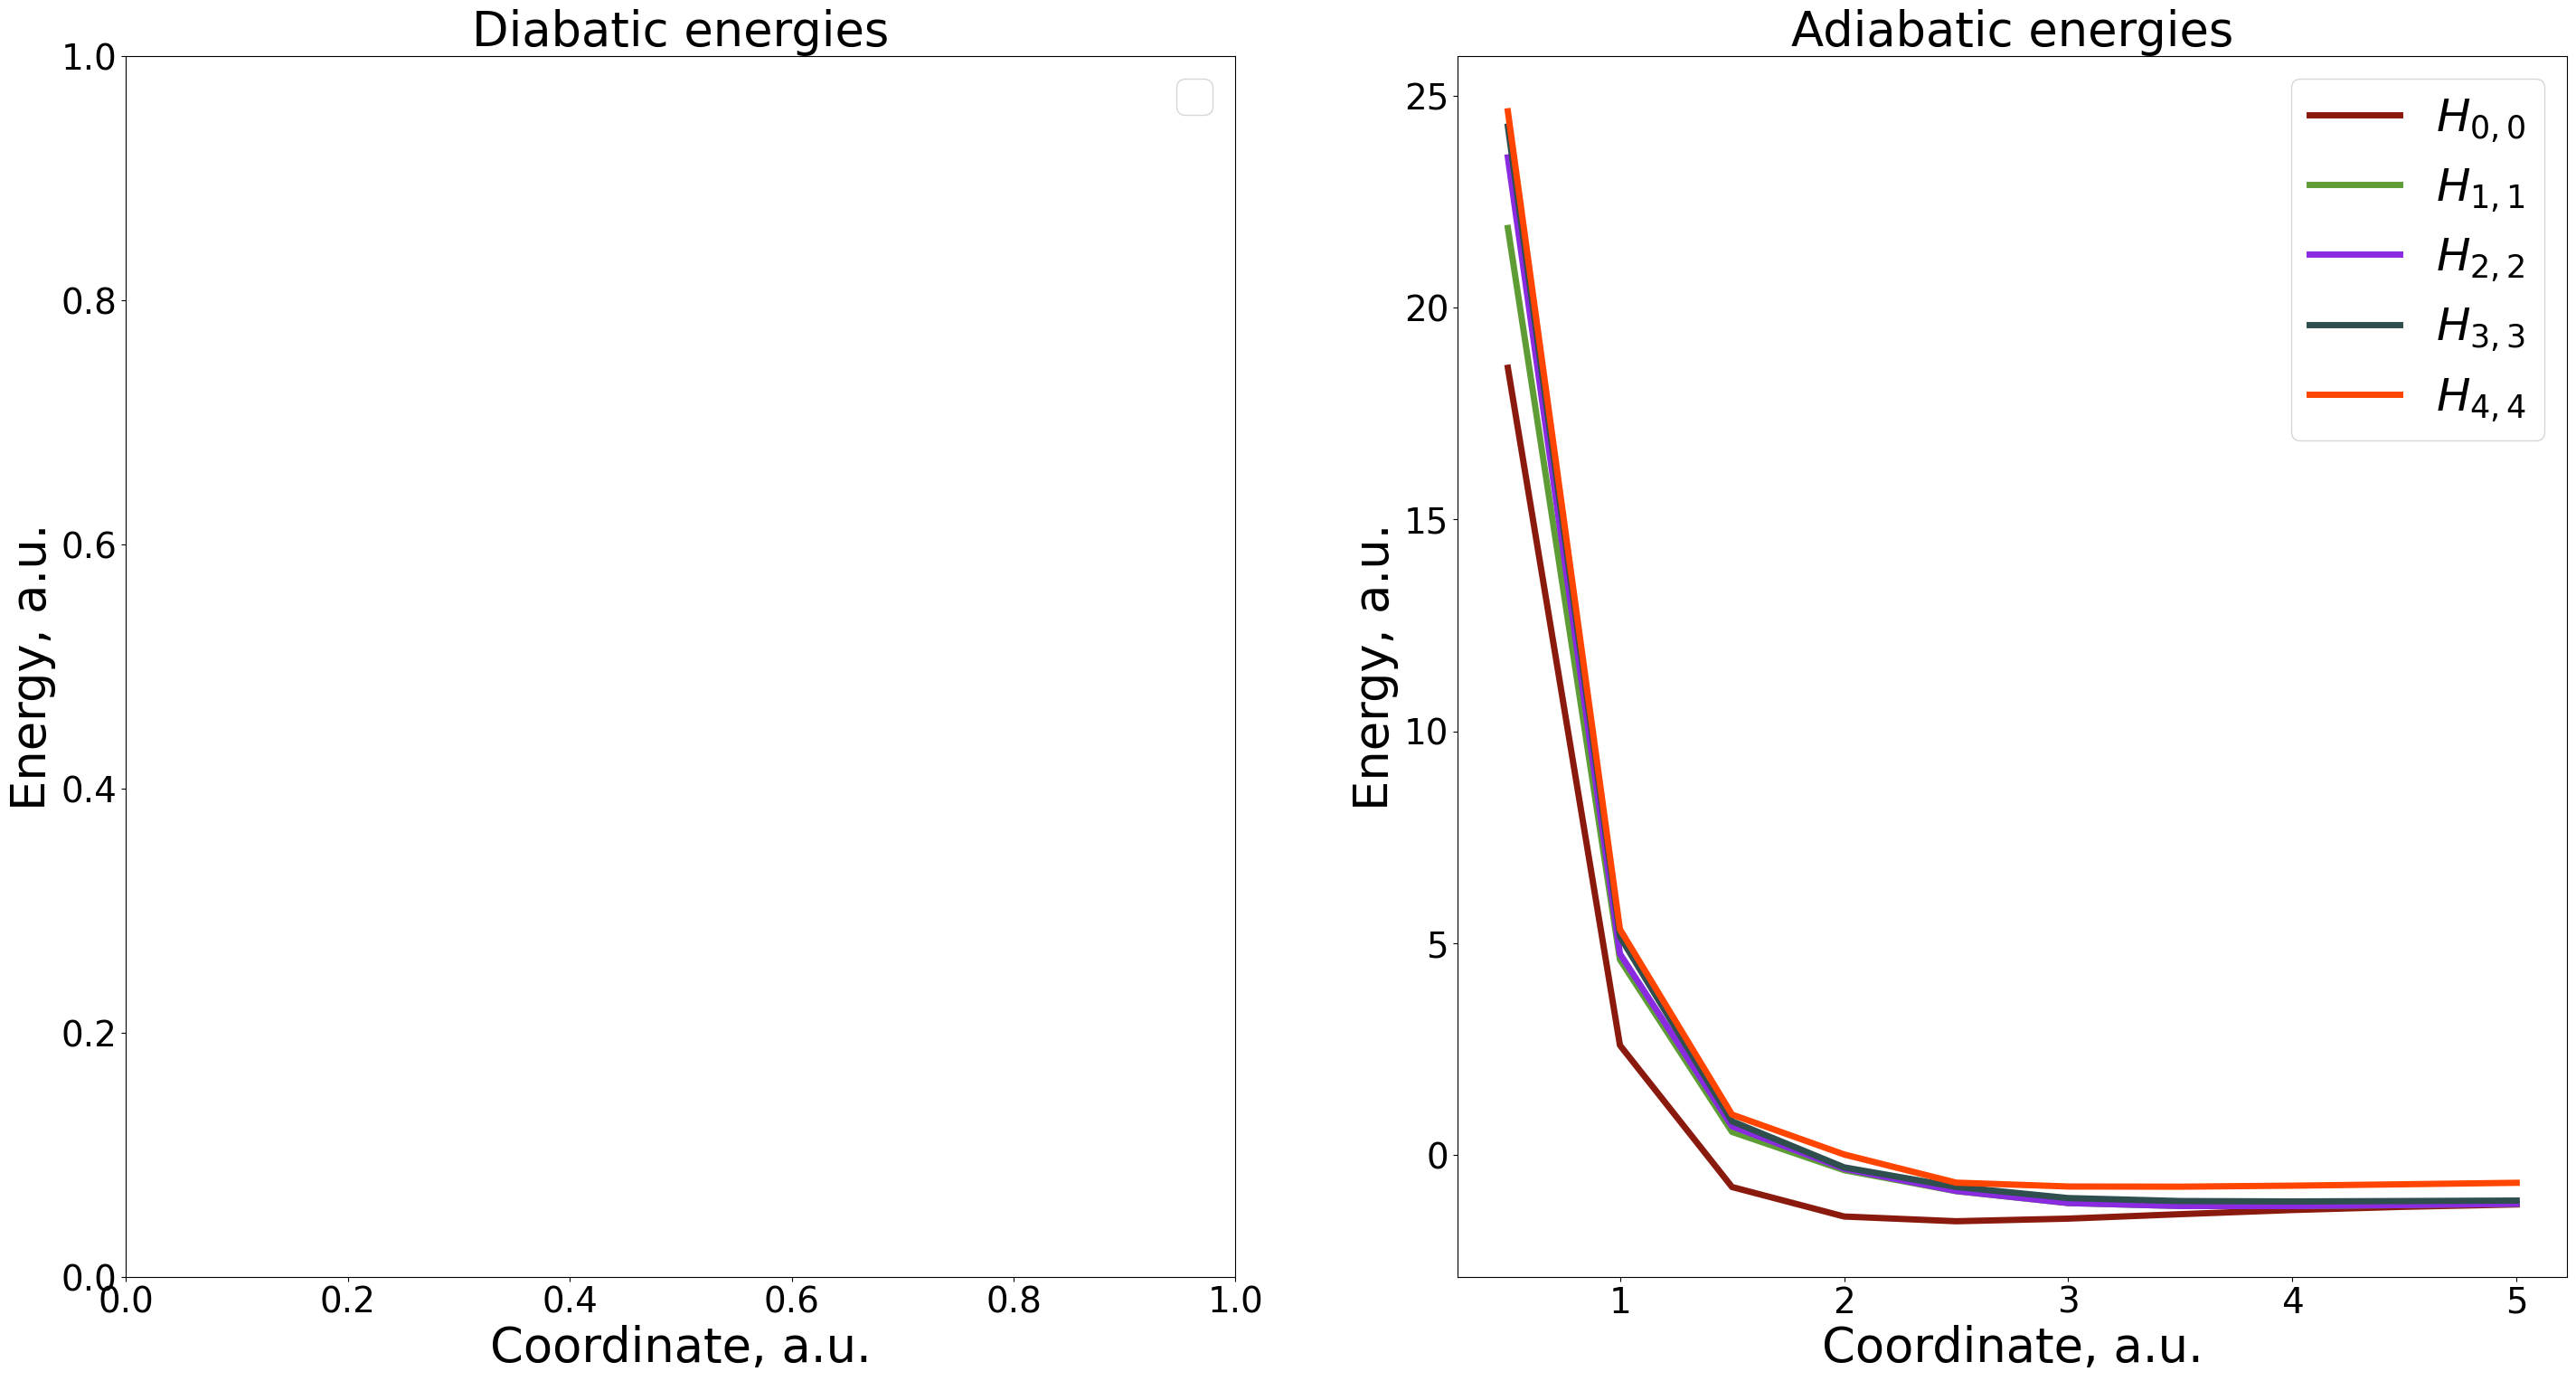

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
labels = ["F", "C", "H", "O"]

q = MATRIX(12,1)
q.set(0,0, -0.04746);  q.set(1,0,  0.65920);  q.set(2,0,  1.04080)
q.set(3,0, -0.51816);  q.set(4,0,  0.81540);  q.set(5,0,  0.06880)
q.set(6,0,  0.15264);  q.set(7,0,  1.00050);  q.set(8,0,  -0.77170)
q.set(9,0, -1.71206);  q.set(10,0, 0.78520);  q.set(11,0, -0.06860)
q *= units.Angst
q.show_matrix()

model_params = { "labels":labels, "nstates":5,
            "dftb_exe":"/home/alexvakimov/SOFTWARE/dftbplus/dftbplus_22.2/_install/bin/dftb+",
            "xyz2gen_exe":"/home/alexvakimov/SOFTWARE/Conda/envs/libra/bin/xyz2gen"
               } 

pes_params = { "ndia":5, "nadi":5, "ndof":12, "active_dof":5,
               "xmin":0.5, "xmax":5.0, "dx":0.5,               
               "coord_mapping":mapping_function,
               "rep_tdse":1, "rep_ham":1  }

plot_params = { "which_ham_adi":[ [0,0], [1,1], [2,2], [3,3], [4,4] ],
                "which_d1ham_adi":[ [5, 0,0], [5, 1,1], [5, 2, 2], [5, 3, 3], [5, 4, 4] ],
                "colors": colors, "clrs_index": clrs_index
              }


HFCO_scan = dynamics_plotting.plot_pes_properties(DFTB_methods.run_dftb_adi, model_params, pes_params, plot_params )

As before, we can collect all the scanned geometries and create the xyz-formatter trajectory "file"

In [1]:
labels = ["F", "C", "H", "O"]
itraj = 0
unit_conversion_factor = 1.0/units.Angst

HFCO_xyz = scan.make_path_xyz2(labels, HFCO_scan, itraj, unit_conversion_factor)

NameError: name 'units' is not defined

that can be used for visualization of the scan

In [19]:
view = py3Dmol.view(width=800,height=400)  
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(HFCO_xyz, 'xyz')
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':1})
view.show()  

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol